In [1]:
# LSTM Implementation with Muhammad Ali Text - Beginner Friendly
# Let's learn how LSTMs work with a simple text prediction example!

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import string

# Our text data about Muhammad Ali
text = """
Muhammad Ali was the greatest boxer of all time. He was born Cassius Clay in Louisville Kentucky. 
Ali won the Olympic gold medal in boxing and became the heavyweight champion of the world. 
He was famous for his quick footwork and powerful punches. Ali was also known for his 
charismatic personality and his famous quote float like a butterfly sting like a bee. 
He changed his name from Cassius Clay to Muhammad Ali when he converted to Islam. 
Ali was stripped of his boxing titles when he refused to serve in the Vietnam War. 
He made a comeback and regained his championship titles. Ali retired from boxing and 
became a global icon for peace and humanitarian work.
"""

print("Our text about Muhammad Ali:")
print(text)
print(f"\nText length: {len(text)} characters")

Our text about Muhammad Ali:

Muhammad Ali was the greatest boxer of all time. He was born Cassius Clay in Louisville Kentucky. 
Ali won the Olympic gold medal in boxing and became the heavyweight champion of the world. 
He was famous for his quick footwork and powerful punches. Ali was also known for his 
charismatic personality and his famous quote float like a butterfly sting like a bee. 
He changed his name from Cassius Clay to Muhammad Ali when he converted to Islam. 
Ali was stripped of his boxing titles when he refused to serve in the Vietnam War. 
He made a comeback and regained his championship titles. Ali retired from boxing and 
became a global icon for peace and humanitarian work.


Text length: 673 characters


In [2]:
# Step 1: Preprocess the text
# Let's clean and prepare our text for the LSTM

# Clean the text (remove extra spaces and convert to lowercase)
text = text.strip().lower()

# Remove punctuation except periods (to keep sentence structure)
text = text.translate(str.maketrans('', '', string.punctuation.replace('.', '')))

print("Cleaned text:")
print(text[:200] + "...")  # Show first 200 characters

# Create character-level vocabulary
chars = sorted(list(set(text)))
vocab_size = len(chars)

print(f"\nUnique characters in our text: {vocab_size}")
print(f"Characters: {chars}")

# Create character to index and index to character mappings
char_to_idx = {char: idx for idx, char in enumerate(chars)}
idx_to_char = {idx: char for idx, char in enumerate(chars)}

print(f"\nExample mappings:")
print(f"'a' -> {char_to_idx['a']}")
print(f"'{idx_to_char[0]}' <- 0")

Cleaned text:
muhammad ali was the greatest boxer of all time. he was born cassius clay in louisville kentucky. 
ali won the olympic gold medal in boxing and became the heavyweight champion of the world. 
he was fa...

Unique characters in our text: 27
Characters: ['\n', ' ', '.', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y']

Example mappings:
'a' -> 3
'
' <- 0


In [3]:
# Step 2: Create sequences for LSTM training
# We'll use a sliding window approach to create input-output pairs

def create_sequences(text, seq_length):
    """Create sequences of characters for training"""
    sequences = []
    targets = []
    
    # Convert text to numbers
    text_encoded = [char_to_idx[char] for char in text]
    
    # Create sequences using sliding window
    for i in range(len(text_encoded) - seq_length):
        sequence = text_encoded[i:i + seq_length]  # Input sequence
        target = text_encoded[i + seq_length]      # Next character to predict
        sequences.append(sequence)
        targets.append(target)
    
    return sequences, targets

# Let's use sequences of length 20 (20 characters to predict the next one)
sequence_length = 20
sequences, targets = create_sequences(text, sequence_length)

print(f"Number of training sequences: {len(sequences)}")
print(f"Sequence length: {sequence_length}")

# Show an example
print(f"\nExample sequence (first 10 numbers): {sequences[0][:10]}")
print(f"Corresponding characters: {''.join([idx_to_char[idx] for idx in sequences[0][:10]])}")
print(f"Target (next character): {targets[0]} -> '{idx_to_char[targets[0]]}'")

Number of training sequences: 651
Sequence length: 20

Example sequence (first 10 numbers): [14, 22, 10, 3, 14, 14, 3, 6, 1, 3]
Corresponding characters: muhammad a
Target (next character): 1 -> ' '


In [4]:
# Step 3: Define our LSTM Model
# This is a simple LSTM that takes character sequences and predicts the next character

class SimpleLSTM(nn.Module):
    def __init__(self, vocab_size, hidden_size, num_layers):
        super(SimpleLSTM, self).__init__()
        
        # Model parameters
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Layers
        self.embedding = nn.Embedding(vocab_size, hidden_size)  # Convert numbers to vectors
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)  # Output layer
        
    def forward(self, x):
        # x shape: (batch_size, sequence_length)
        
        # Convert to embeddings
        embedded = self.embedding(x)  # (batch_size, seq_len, hidden_size)
        
        # Pass through LSTM
        lstm_out, _ = self.lstm(embedded)  # (batch_size, seq_len, hidden_size)
        
        # Use only the last output for prediction
        last_output = lstm_out[:, -1, :]  # (batch_size, hidden_size)
        
        # Get final prediction
        output = self.fc(last_output)  # (batch_size, vocab_size)
        
        return output

# Create our model
hidden_size = 64  # Size of LSTM hidden state
num_layers = 2    # Number of LSTM layers

model = SimpleLSTM(vocab_size, hidden_size, num_layers)
print(f"\nModel created!")
print(f"Vocabulary size: {vocab_size}")
print(f"Hidden size: {hidden_size}")
print(f"Number of LSTM layers: {num_layers}")
print(f"\nModel architecture:")
print(model)


Model created!
Vocabulary size: 27
Hidden size: 64
Number of LSTM layers: 2

Model architecture:
SimpleLSTM(
  (embedding): Embedding(27, 64)
  (lstm): LSTM(64, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=27, bias=True)
)


In [5]:
# Step 4: Prepare data for training
# Convert our sequences to PyTorch tensors

# Convert to tensors
X = torch.tensor(sequences, dtype=torch.long)  # Input sequences
y = torch.tensor(targets, dtype=torch.long)    # Target characters

print(f"Input tensor shape: {X.shape}")  # (num_sequences, sequence_length)
print(f"Target tensor shape: {y.shape}")  # (num_sequences,)

# Create a simple train-test split
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"\nTraining samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Good for classification tasks
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

print(f"\nTraining setup complete!")
print(f"Loss function: CrossEntropyLoss")
print(f"Optimizer: Adam with learning rate 0.01")

Input tensor shape: torch.Size([651, 20])
Target tensor shape: torch.Size([651])

Training samples: 520
Testing samples: 131

Training setup complete!
Loss function: CrossEntropyLoss
Optimizer: Adam with learning rate 0.01

Training setup complete!
Loss function: CrossEntropyLoss
Optimizer: Adam with learning rate 0.01


In [6]:
# Step 5: Train the LSTM
# Let's train our model to predict the next character

# Training parameters
num_epochs = 50
batch_size = 32

# Lists to store training progress
losses = []

print("Starting training...")
print("="*50)

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    num_batches = 0
    
    # Process data in batches
    for i in range(0, len(X_train), batch_size):
        # Get batch
        batch_X = X_train[i:i+batch_size]
        batch_y = y_train[i:i+batch_size]
        
        # Forward pass
        optimizer.zero_grad()  # Clear gradients
        outputs = model(batch_X)  # Get predictions
        loss = criterion(outputs, batch_y)  # Calculate loss
        
        # Backward pass
        loss.backward()  # Calculate gradients
        optimizer.step()  # Update weights
        
        epoch_loss += loss.item()
        num_batches += 1
    
    # Calculate average loss for this epoch
    avg_loss = epoch_loss / num_batches
    losses.append(avg_loss)
    
    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

print("\nTraining completed!")
print("="*50)

Starting training...
Epoch [10/50], Loss: 0.7334
Epoch [10/50], Loss: 0.7334
Epoch [20/50], Loss: 0.0756
Epoch [20/50], Loss: 0.0756
Epoch [30/50], Loss: 0.0567
Epoch [30/50], Loss: 0.0567
Epoch [40/50], Loss: 0.0098
Epoch [40/50], Loss: 0.0098
Epoch [50/50], Loss: 0.0069

Training completed!
Epoch [50/50], Loss: 0.0069

Training completed!


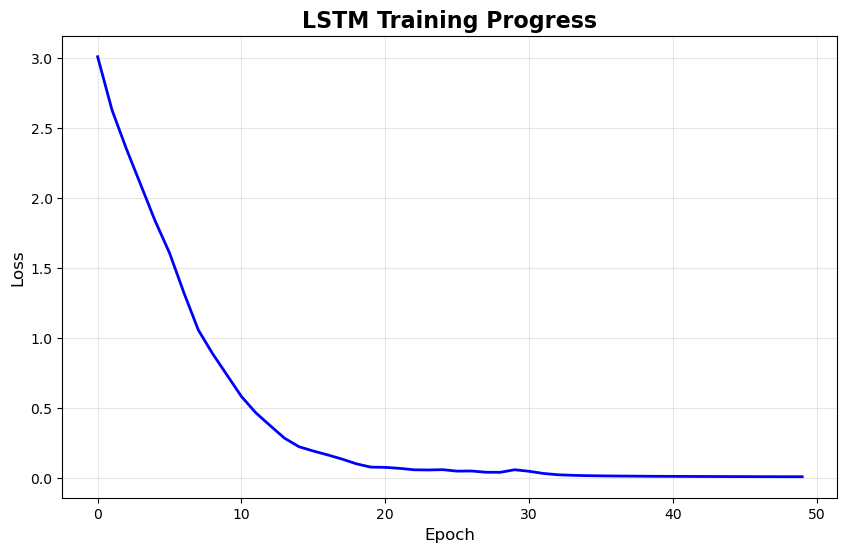

Final training loss: 0.0069
Starting loss: 3.0095
Improvement: 99.8%


In [7]:
# Step 6: Visualize training progress
# Let's see how our model learned over time

plt.figure(figsize=(10, 6))
plt.plot(losses, 'b-', linewidth=2)
plt.title('LSTM Training Progress', fontsize=16, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

print(f"Final training loss: {losses[-1]:.4f}")
print(f"Starting loss: {losses[0]:.4f}")
print(f"Improvement: {((losses[0] - losses[-1]) / losses[0] * 100):.1f}%")

In [8]:
# Step 7: Generate text with our trained LSTM
# This is the fun part - let's see what our model learned!

def generate_text(model, start_text, length=100):
    """Generate text using our trained LSTM"""
    model.eval()  # Set to evaluation mode
    
    # Convert start text to numbers
    current_seq = [char_to_idx[char] for char in start_text.lower()]
    generated_text = start_text.lower()
    
    with torch.no_grad():  # Don't calculate gradients during generation
        for _ in range(length):
            # Take the last sequence_length characters
            if len(current_seq) > sequence_length:
                input_seq = current_seq[-sequence_length:]
            else:
                # Pad with spaces if too short
                input_seq = current_seq + [char_to_idx[' ']] * (sequence_length - len(current_seq))
            
            # Convert to tensor
            input_tensor = torch.tensor([input_seq], dtype=torch.long)
            
            # Get prediction
            output = model(input_tensor)
            
            # Get the character with highest probability
            predicted_idx = torch.argmax(output, dim=1).item()
            predicted_char = idx_to_char[predicted_idx]
            
            # Add to our sequence and generated text
            current_seq.append(predicted_idx)
            generated_text += predicted_char
    
    return generated_text

print("Text generation function ready!")
print("Let's test it with different starting phrases...")

Text generation function ready!
Let's test it with different starting phrases...


In [9]:
# Step 8: Test our LSTM with different starting phrases
# Let's see how well it learned about Muhammad Ali!

start_phrases = [
    "muhammad ali was",
    "ali won",
    "he was famous",
    "boxing"
]

print("Generated Text Examples:")
print("="*60)

for i, phrase in enumerate(start_phrases, 1):
    print(f"\n{i}. Starting with: '{phrase}'")
    print("-" * 40)
    generated = generate_text(model, phrase, length=80)
    print(generated)
    print()

print("\nCustom generation - you can try your own!")
print("-" * 40)
custom_start = "ali became"
generated = generate_text(model, custom_start, length=100)
print(f"Starting with: '{custom_start}'")
print(generated)

Generated Text Examples:

1. Starting with: 'muhammad ali was'
----------------------------------------
muhammad ali wastnccame was also known for his 
charismatic personality and his famous quote flo


2. Starting with: 'ali won'
----------------------------------------
ali wontttttttlllcccky was also known for his 
charismatic personality and his famous q


3. Starting with: 'he was famous'
----------------------------------------
he was famousttttlccvilate float like a butterfly sting like a bee. 
he changed his name from


4. Starting with: 'boxing'
----------------------------------------
boxingtttttttttlllcc champion of the world. 
he was famous for his quick footwork and 


Custom generation - you can try your own!
----------------------------------------
Starting with: 'ali became'
ali becamettttnnnccppe for his 
charismatic personality and his famous quote float like a butterfly sting like
boxingtttttttttlllcc champion of the world. 
he was famous for his quick footwork and 



In [10]:
# Step 9: Evaluate our model's performance
# Let's see how well it predicts the next character on test data

model.eval()
correct_predictions = 0
total_predictions = 0

with torch.no_grad():
    for i in range(len(X_test)):
        # Get prediction for test sample
        input_seq = X_test[i].unsqueeze(0)  # Add batch dimension
        output = model(input_seq)
        predicted = torch.argmax(output, dim=1).item()
        actual = y_test[i].item()
        
        if predicted == actual:
            correct_predictions += 1
        total_predictions += 1

accuracy = correct_predictions / total_predictions * 100

print(f"Model Evaluation Results:")
print("="*40)
print(f"Test Accuracy: {accuracy:.2f}%")
print(f"Correct predictions: {correct_predictions}/{total_predictions}")

# Let's also show some prediction examples
print(f"\nSome prediction examples:")
print("-" * 30)

for i in range(5):  # Show first 5 test examples
    input_seq = X_test[i]
    actual_next = y_test[i].item()
    
    # Convert sequence to text
    input_text = ''.join([idx_to_char[idx.item()] for idx in input_seq])
    actual_char = idx_to_char[actual_next]
    
    # Get model prediction
    with torch.no_grad():
        output = model(input_seq.unsqueeze(0))
        predicted_idx = torch.argmax(output, dim=1).item()
        predicted_char = idx_to_char[predicted_idx]
    
    print(f"Input: '{input_text[-15:]}...'")
    print(f"Actual next: '{actual_char}' | Predicted: '{predicted_char}' | {'✓' if predicted_char == actual_char else '✗'}")
    print()

Model Evaluation Results:
Test Accuracy: 40.46%
Correct predictions: 53/131

Some prediction examples:
------------------------------
Input: ' war. 
he made ...'
Actual next: 'a' | Predicted: 't' | ✗

Input: 'war. 
he made a...'
Actual next: ' ' | Predicted: 'l' | ✗

Input: 'ar. 
he made a ...'
Actual next: 'c' | Predicted: 'b' | ✗

Input: 'r. 
he made a c...'
Actual next: 'o' | Predicted: 'a' | ✗

Input: '. 
he made a co...'
Actual next: 'm' | Predicted: 'n' | ✗



## 🎉 Congratulations! You've Built Your First LSTM!

### What We Just Did:

1. **Text Preprocessing**: We cleaned the Muhammad Ali text and created a character-level vocabulary
2. **Sequence Creation**: We created sliding windows of text to train our LSTM
3. **Model Architecture**: We built a simple LSTM with embedding, LSTM layers, and output layer
4. **Training**: We trained the model to predict the next character in a sequence
5. **Text Generation**: We used the trained model to generate new text
6. **Evaluation**: We measured how well our model performs

### Key LSTM Concepts Demonstrated:

- **Sequential Learning**: The LSTM learns patterns in sequences of characters
- **Memory**: The hidden states help the model remember previous context
- **Character-level Prediction**: Each step predicts the next character
- **Text Generation**: By repeatedly predicting the next character, we can generate text

### Why This Works:

- The LSTM learns common character patterns in English
- It picks up on word boundaries, common phrases, and writing style
- With more training data and epochs, it would generate even better text!

### Next Steps to Improve:

1. **More Data**: Use larger text datasets
2. **Word-level**: Try word-level instead of character-level
3. **Larger Model**: Increase hidden size and layers
4. **Better Sampling**: Use temperature sampling instead of argmax
5. **Bidirectional LSTM**: Look at context from both directions

Great job learning LSTMs! 🚀